## systems.py

Recall that the state-space model of a continuous-time dynamical system is given by:

$$
\begin{aligned}
\dot{x} &= f(x, u, t) + w(t) \\
y &= h(x, u, t) + r(t)
\end{aligned}
$$

There are four functions that define the input-output behavior of the system: $f$, $h$, $w$, and $r$. `pykal` binds these functions into a system object. Only the names of the system states are required to initialize an instance of the `System` class.

In [1]:
from pykal_core.control_system.system import System

sys = System(state_names=['x0','x1'])

Note that `sys` has the following attributes:

In [2]:
for key, value in sys.__dict__.items():
    print(f"{key}: {value}")

safeio: <pykal_core.control_system.system.System.SafeIO object at 0x71d52430cb90>
_state_names: ['x0', 'x1']
_measurement_names: ['x0_meas', 'x1_meas']
_system_type: cti
_f: <function System.f_zero at 0x71d554601a80>
_h: <function System.h_identity at 0x71d5236282c0>
_Q: <function System.make_Q.<locals>.Q at 0x71d56c621080>
_R: <function System.make_R.<locals>.R at 0x71d57412e2a0>


The default dynamics return a zero derivative vector. The default measurement model is full-state and unweighted. The default $Q$ and $R$ are diagonal matrices with uniform noise across states and measurements.

In [3]:
import numpy as np
x0 = np.array([[1.0], [0.0]])
print(f"sys.f(x0):\n{sys.f(x0)}\n")
print(f"sys.h(x0):\n{sys.h(x0)}\n")
print(f"sys.Q():\n{sys.Q()}\n")
print(f"sys.R():\n{sys.R()}\n")

sys.f(x0):
[[0.]
 [0.]]

sys.h(x0):
[[1.]
 [0.]]

sys.Q():
[[0.01 0.  ]
 [0.   0.01]]

sys.R():
[[0.01 0.  ]
 [0.   0.01]]



We now simulate the system states and measurements. Since the dynamics are zero, the only variation comes from noise.

<Axes: title={'center': 'State and Measurement Trajectories'}, xlabel='time', ylabel='Values'>

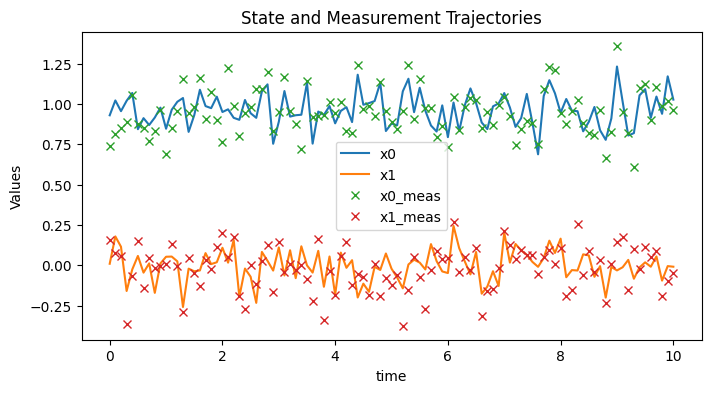

In [4]:
import numpy as np
from pykal_core.utils import compute
x0 = np.array([[1.0], [0.0]])

X_df = compute.Simulation.of_state_trajectories(sys=sys, 
                                                x0=x0,
                                                t_span=(0, 10),
                                                dt=0.1,
                                                output_df=True)

ax = X_df.plot(title="State and Measurement Trajectories", xlabel="Time", ylabel="Values", figsize=(8, 4))

Y_df = compute.Simulation.of_measurements(sys=sys,
                                            X_df = X_df,
                                            t_span=(0, 10), 
                                            dt=0.1, 
                                            input_df=True,
                                            output_df=True)

Y_df.plot(ax=ax,linestyle='None', marker='x', markersize=6)

Let's try a more interesting example: the harmonic oscillator.

### Example: The Simple Harmonic Oscillator

Consider a mass $m$ (units: kg) attached to a spring with stiffness $k$ (units: N/m), constrained to move on a flat surface without friction. The displacement from equilibrium is denoted by $x(t)$, and the origin is placed at $x = 0$.

The **state-space model** of the system is
$$
\frac{d}{dt} \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix}
= \begin{bmatrix}
\dot{x}(t) \\
-\frac{k}{m} x(t)
\end{bmatrix}
$$

We define the state vector as $\mathbf{x}(t) = \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix}$ and by inspection, conclude the dynamics are
$$
f(\mathbf{x}) = \begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & 0 \end{bmatrix} \mathbf{x}
$$

This is the continuous-time system for a simple harmonic oscillator. Now let's suppose our measurement function only accesses position:

$$
y(t) = h(\mathbf{x}) = \begin{bmatrix} 1 & 0 \end{bmatrix} \mathbf{x}(t)
$$

How do we model this in `pykal`? For now, lets assume $k=m=1$.

In [5]:
from numpy.typing import NDArray

def f_simple_dynamics(xk: NDArray) -> NDArray: # k = m = 1
    A = np.array([[0, 1],
                  [-1, 0]])  
    return A @ xk

def h_position(xk:NDArray) -> NDArray:
    return np.atleast_2d(xk[0])

sho = System(state_names=['x0','x1'],measurement_names=["x0_meas"],f=f_simple_dynamics,h=h_position)

<Axes: title={'center': 'State and Measurement Trajectories'}, xlabel='time', ylabel='Values'>

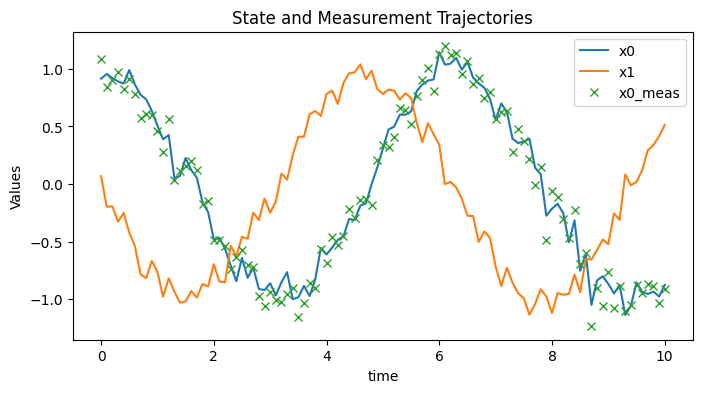

In [6]:
x0 = np.array([[1.0], [0.0]])

X_df = compute.Simulation.of_state_trajectories(sys=sho, 
                                                x0=x0,
                                                t_span=(0, 10),
                                                dt=0.1,
                                                output_df=True)

ax = X_df.plot(title="State and Measurement Trajectories", xlabel="Time", ylabel="Values", figsize=(8, 4))

Y_df = compute.Simulation.of_measurements(sys=sho,
                                            X_df = X_df,
                                            t_span=(0, 10), 
                                            dt=0.1, 
                                            input_df=True,
                                            output_df=True)

Y_df.plot(ax=ax,linestyle='None', marker='x', markersize=6)


But what if we want to change the dynamics, say for a different spring constant $k$ or mass $m$?

In `pykal`, there's no need to redefine or reinstantiate the entire system. You can override any function—such as the dynamics $f$—at runtime using the `override_system_f` argument in simulation or filter methods. This makes it easy to test different models or parameters without creating a new `System` object each time.

In [7]:
from typing import Callable

def make_mass_spring_dynamics(k: float = 1.0, m: float = 1.0) -> Callable[[NDArray], NDArray]:
    def f_mass_spring(x: NDArray) -> NDArray:
        x1, x2 = x[0, 0], x[1, 0]
        dx1 = x2
        dx2 = - (k / m) * x1
        return np.array([[dx1], [dx2]])

    return f_mass_spring

We can now play around with different dynamics by overriding the system function using `override_system_f`. This lets us test different values of $k$ and $m$ without redefining the whole system.

Likewise, we can override the noise models using `System.make_Q(...)` and `System.make_R(...)` to adjust process and measurement noise on the fly.

<Axes: title={'center': 'State and MeasurementTrajectories'}, xlabel='time', ylabel='Value'>

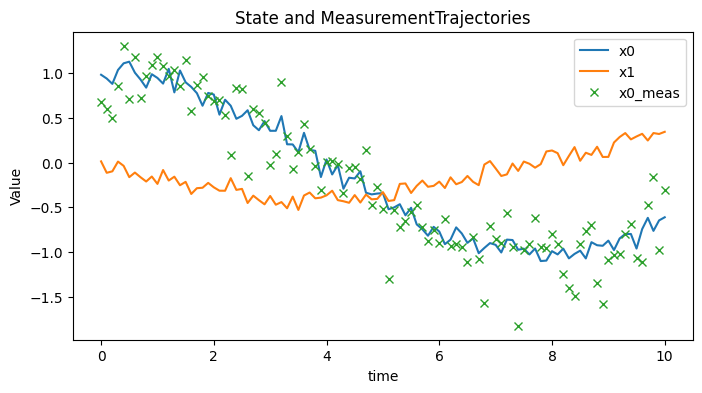

In [8]:
X_df = compute.Simulation.of_state_trajectories(sys=sho, 
                                                x0=x0,
                                                t_span=(0, 10),
                                                dt=0.1,
    override_system_f=make_mass_spring_dynamics(k=0.69,m=4.20),
    override_system_Q=System.make_Q(state_names=["x0","x1"],create_Q_from_list=[0.69,0.420]),
                                                output_df=True)

ax = X_df.plot(title="State and MeasurementTrajectories", xlabel="Time", ylabel="Value", figsize=(8, 4))

Y_df = compute.Simulation.of_measurements(sys=sho,
                                            X_df = X_df,
                                            t_span=(0, 10), 
                                            dt=0.1, 
    override_system_R=System.make_R(measurement_names=["x0_meas"],multiply_R_by_scalar=0.069),
                                            input_df=True,
                                            output_df=True)

Y_df.plot(ax=ax,linestyle='None', marker='x', markersize=6)

Once we've decided on the parameters we like, we can instantiate a new `System` with the chosen dynamics and noise models. If we give it the same name as our old one, we replace the old one in the name space.

In [9]:
sho = System(state_names=['x0','x1'],
             measurement_names=["x0_meas"],
             f=make_mass_spring_dynamics(k=0.69,m=4.20),
             Q = System.make_Q(state_names=["x0","x1"],create_Q_from_list=[0.69,0.420]),
             R = System.make_R(measurement_names=["x0_meas"],multiply_R_by_scalar=0.069),
             h=h_position)

## signals.py
Now let's add an input signal.

Recall that for the mass-spring system with an external force input $u(t)$ (units: N), the dynamics become:

$$
\frac{d}{dt} \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix}
= \begin{bmatrix}
\dot{x}(t) \\
-\frac{k}{m} x(t) + \frac{1}{m} u(t)
\end{bmatrix}
$$

This corresponds to the state-space form:
$$
f(\mathbf{x}, u) = \begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & 0 \end{bmatrix} \mathbf{x} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u
$$

Here, the control input $u(t)$ acts as an external force scaled by $1/m$. This allows us to drive or perturb the system externally by choosing different input signals.


In [10]:
def make_mass_spring_dynamics_with_input(k: float = 1.0, m: float = 1.0) -> Callable[[NDArray, NDArray], NDArray]:
    def f_mass_spring_with_input(x: NDArray, u: NDArray) -> NDArray:
        x1, x2 = x[0, 0], x[1, 0]
        u_val = u[0, 0]
        dx1 = x2
        dx2 = - (k / m) * x1 + (1 / m) * u_val
        return np.array([[dx1], [dx2]])

    return f_mass_spring_with_input 

In [11]:
sho.f = make_mass_spring_dynamics_with_input(k=0.69,m=4.20)

In [12]:
from pykal_core.control_system.signals import Signals
signal_generator = Signals(sys=sho)

In [13]:
for key, value in signal_generator.__dict__.items():
    print(f"{key}: {value}")

sys: <pykal_core.control_system.system.System object at 0x71d4f41b5670>
generate: <pykal_core.control_system.signals.Generate object at 0x71d4f4157e90>


In [14]:
signal_generator.sys.safeio

In [15]:
Udf = compute.Simulation.of_signals(signal_generator,
                                    signal_generator.generate.make_constant_signal([6,9]),
                                    t_span=(0,10),
                                    dt=0.1,
                                    output_df=True)
Udf.plot()

AttributeError: 'Signals' object has no attribute 'safeio'

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

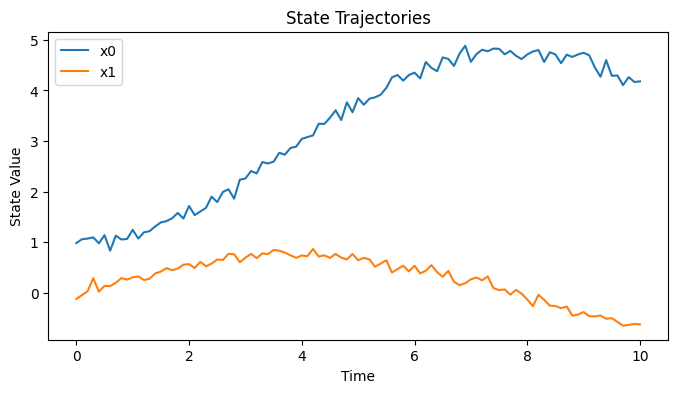

In [ ]:
X_df = compute.Simulation.of_state_trajectories(sys=sho, 
                                                x0=x0,
                                                t_span=(0, 10),
                                                signal=signal_generator.generate.make_constant_signal([2,0]),
                                                dt=0.1,
                                                output_df=True)

X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

Let us test out a possible input before we set it to a controller. 

In [ ]:
def make_u_square_wave(amplitude=10.0, period=2.0) -> Callable[[float], NDArray[np.float64]]:
    def u(t: float) -> NDArray[np.float64]:
        sign = 1.0 if (t % period) < (period / 2) else -1.0
        return np.array([[sign * amplitude], [0.0]], dtype=np.float64)
    return u    

<Axes: >

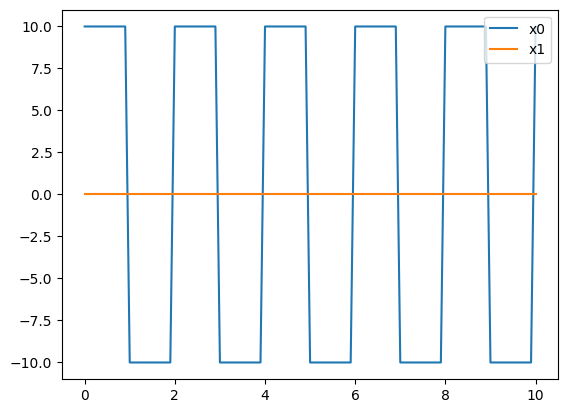

In [ ]:
Udf = compute.Simulation.of_signals(signal_generator,
                                     make_u_square_wave(amplitude=10.0, period=2.0),
                                    t_span=(0,10),
                                    dt=0.1,
                                    output_df=True)
Udf.plot()

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

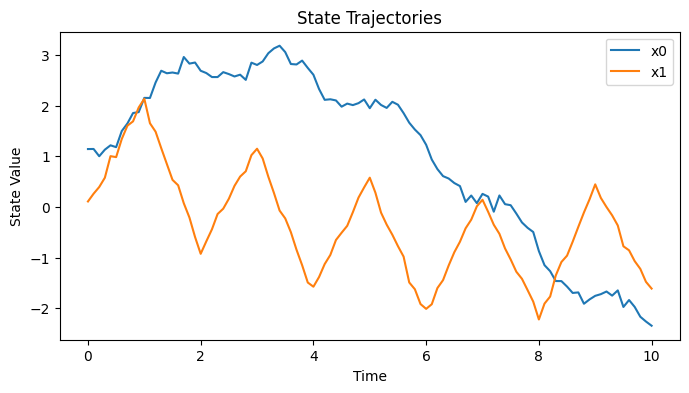

In [ ]:
X_df = compute.Simulation.of_state_trajectories(sys=sho, 
                                                x0=x0,
                                                t_span=(0, 10),
                                                signal=make_u_square_wave(amplitude=10.0, period=2.0),
                                                dt=0.1,
                                                output_df=True)

X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

In [ ]:
signal_generator.user_signal = make_u_square_wave(amplitude=10.0, period=2.0)

Dynamic coupling; they are only coupled upon instantiation. Make no mistake, this controller is associated with this system and has algorithms like PID in signals that onlhy make sense for this system, but in terms of the system API, it can get its control from anywhere. This is very important; it enables great flexibilty and captures the underlying mathematics much more clearly. Because of dynamic coupling, we can create systems of arbitrary complexity by simply changing our calling functions. 

In [ ]:
X_df = compute.Simulation.of_state_trajectories(sys=harmonic_oscillator, 
                                                x0=x0,
                                                t_span=(0, 10),
                                                dt=0.1,
    override_system_f=make_oscillator_dynamics_with_input(omega=0.1,zeta=0.2),
    controller_u=make_u_square_wave(amplitude=5,period=1),
                                                output_df=True)

You might wonder: why bother with setting object attributes if we can just override them when we call the simulation? This is because we will need those attributes once we transfer ffrom the dynamic coupling enabled in Python to the static object-based nodes of ROS. For prototyping, its good to stay fluid. Once we have somethin gwe want to test in hardware, we set and go.  

If we want multiple control inputs on a system, thats also easy. We can define a bunch of us and pass them in to one meta u, and if we decide to formalize things, we can make a controller that does this. 

Now lets make an observer. 

Let us create now a coupled system of oscillators with an observer for the output, a controller for the input of the first oscillator, a controller bridging the output of the first to the seccond, and then an observer at the second. 

# Creating a Dynamical System

## The State-Space Model

Recall that the state-space model of continuous-time dynamical system is given by:

$$
\begin{aligned}
\dot{x} &= f(x, u, t) + w(t) \\
y &= h(x, u, t) + r(t)
\end{aligned}
$$

where $x \in \mathbb{R}^{n}$ is the **state vector**, $u \in \mathbb{R}^{p}$ is the **input vector**, $t \in \mathbb{R}^{+}$ is **time**, and $w$ is a random variable referred to as **process noise** with $w(t) \in \mathbb{R}^{n}$ distributed as $w \sim \mathcal{N}(0, Q(t))$, where $Q(t) \in \mathcal{M}_{n}(\mathbb{R})$ is the positive semidefinite **process noise covariance matrix**.

Similarly, $y \in \mathbb{R}^{m}$ is the **measurement vector**, and $r$ is a random variable referred to as **measurement noise** with $r(t) \in \mathbb{R}^{m}$ distributed as $r \sim \mathcal{N}(0, R(t))$, where $R(t) \in \mathcal{M}_{m}(\mathbb{R})$ is the positive semidefinite **measurement noise covariance matrix**.


## The State-Space Model as a `System` class

The state-space model lends itself well to being represented as a class -- indeed, it would be an insult to the gods of programming to do it any other way. 

We define a `System` class which encapsulates the process dynamics (`f`), the measurement dynamics (`h`), a vector-valued input function (`u`), the process noise (from `Q`), and the measurement noise ( from `R`). 

Every instance of the `System` class encapsulates a new system, and—with the exception of metadata such as state names and measurement names—each instance of `System` encapsulates **behaviour**, not data.

We consider as an illustrative example the representation of a simple harmonic oscillator. 

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pykal.control_system.system import System
from numpy.typing import NDArray

def f(x: NDArray) -> NDArray:
    return np.array([[x[1, 0]], [-x[0, 0]]])  # Harmonic oscillator


sys = System(state_names=['x0','x1'])

In [ ]:
print(sys.__dict__)

{'safeio': <pykal.control_system.system.System.SafeIO object at 0x782cbe23d5e0>, '_state_names': ['x0', 'x1'], '_measurement_names': ['x0', 'x1'], '_system_type': 'cti', '_f': <function System.f_zero at 0x782ced8c0680>, '_h': <function System.h_identity at 0x782ced8c2200>, '_Q': <function System.make_Q.<locals>.Q at 0x782cbe2f8040>, '_R': <function System.make_R.<locals>.R at 0x782cbe2f8180>}


Sevaral things to note:
- the methods`sys.h`, `sys.u`, `sys.Q`, and `sys.R` are initialized by default.
- the attributes `sys.measurement_names` and `sys.input_names` are initialized by default. 

In [ ]:
print("Default System functions:")
print(f"  h: {sys.h.__name__}")
print(f"  u: {sys.u.__name__}")
print(f"  Q: {sys.Q.__name__}")
print(f"  R: {sys.R.__name__}")

Default System functions:
  h: h_identity


AttributeError: 'System' object has no attribute 'u'

## Simulating State Trajectories

We can now simulate the trajectory of the states by specifying an initial condition `x0`, a time span `t_span`, and a time step `dt`. 

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

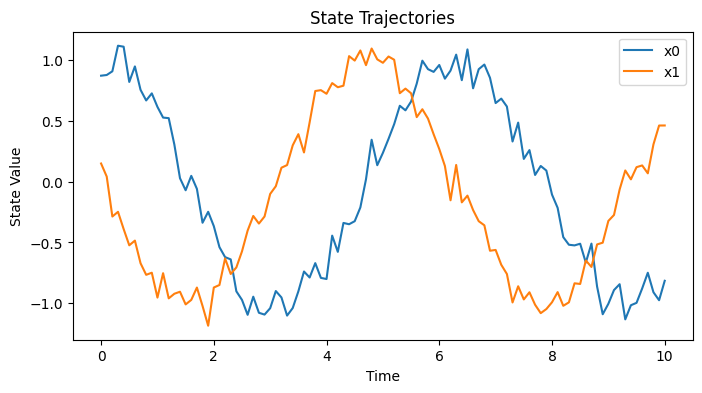

In [ ]:
x0 = np.array([[1.0], [0.0]])
X_df = sys.simulate_states(x0=x0, dt=0.1, t_span=(0, 10),output_df=True) # X is (n_states,n_timesteps), T is (n_timesteps,)
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

Nothing terribly impressive. But suppose we decided we wanted to see what this looked like with no process noise instead of 'minimal'. We could define a zero-noise function and update our system, like so:  

In [ ]:
def no_process_noise() -> NDArray:
    return np.zeros((2,2))

sys.Q = no_process_noise

<Axes: title={'center': 'State Trajectories with No Noise'}, xlabel='Time', ylabel='State Value'>

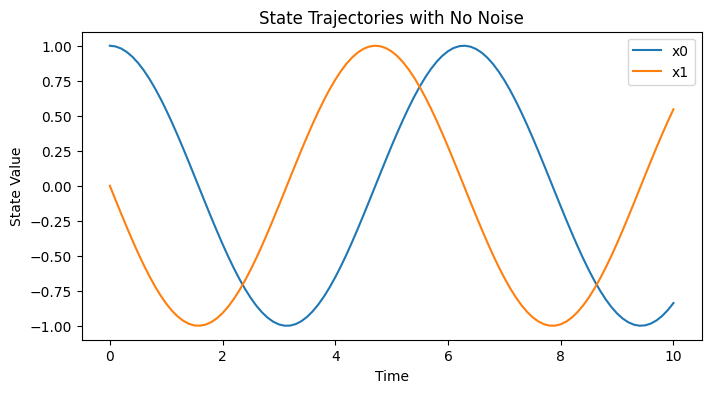

In [ ]:
X_df= sys.simulate_states(x0=x0, dt=0.1, t_span=(0, 10),output_df=True) 
X_df.plot(title="State Trajectories with No Noise", xlabel="Time", ylabel="State Value", figsize=(8, 4))

## Overriding`System` Attributes for Rapid Exploration

Suppose we wanted to visually assess a suite of different process noise functions. It would soon become tiresome to reset `sys.Q` every time. If only, in addition to being quite handsome, the author of this package was intelligent enough to offer a faster alternatice to rapid testing. Let's see. 

Let us define a new proccess noise function,

In [ ]:
def test_process_noise() -> NDArray:
    return 0.01 * np.eye(2)

We now simulate our system with an **override** on our `sys.Q`.

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

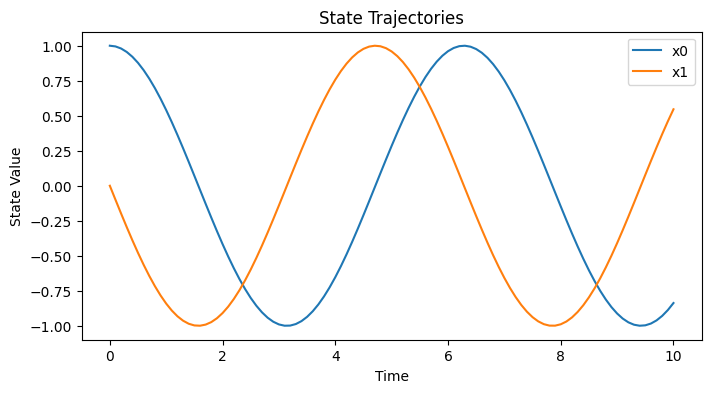

In [ ]:
X, T = sys.simulate_states(x0=x0, dt=0.1, t_span=(0, 10), override_system_Q=test_process_noise,output_df=True) 
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

We have simulated our system with quite a lot of noise, but the system itself remains unchanged from when we last updated it. 

In [ ]:
sys.Q.__name__

'no_process_noise'

Indeed, this override behavior works for **all** system attributes and bound methods! You will see many examples of it in this notebook and the notebooks to follow. Here is the parameter argument:
- `override_* = False`: uses current `sys.*` (default)
- `override_* = None`: set current `sys.*` to "zero"(see documentation for more info)
- `override_* = func: Callable`: call `func` instead of `sys.*`
- `override_* = new_names: list[str]`: use `new_names` instead of `sys.*` (used for new state names, measurement names, and input names.
  
In fact, the only property of a system you cannot override is its time structure.

Let us now test our system with a constant input function, that is, a **driven harmonic oscillator**. This will require us to write an write a `u` function and rewrite `f` as well. 

In [ ]:
def u_square_wave(t: float, amplitude: float = 10.0, period: float = 2.0) -> NDArray[np.float64]:
    sign = 1.0 if (t % period) < (period / 2) else -1.0
    return np.array([[sign * amplitude]], dtype=np.float64)

    
def driven_SHO(
      x: NDArray[np.float64],
      u: NDArray[np.float64],
      damping_term: float = 0.1,
      stiffness: float = 2.0,
  ) -> NDArray[np.float64]:
      x0, x1 = x[0, 0], x[1, 0]
      u_val = u[0, 0]
      dx0 = x1
      dx1 = -stiffness * x0 - damping_term * x1 + u_val
      return np.array([[dx0], [dx1]], dtype=np.float64)

We now have:

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

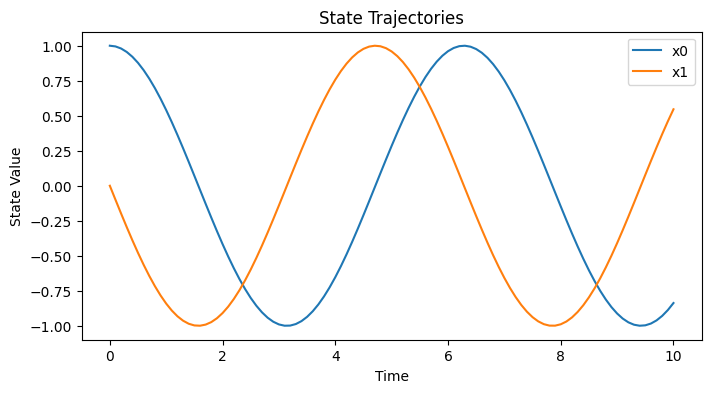

In [ ]:
X, T = sys.simulate_states(x0=x0, dt=0.1, t_span=(0, 10), 
                           override_system_f=driven_SHO, 
                           override_system_Q=test_process_noise, 
                           override_system_u=u_square_wave, 
                           override_system_input_names=["force"],
                           output_df=True)
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

But wait! We defined our new system functions with keyword arguments. If we wanted to change those parameters for our simulation, we *could* redefine our functions with different default values for the keywords. But with `pykal`, there's a much quicker way: we write closures. 

In [ ]:
from typing import Callable
def driven_SHO_with_params(
      damping_term: float = 0.1,
      stiffness: float = 2.0,
  ) -> Callable:
      def driven_SHO(
          x: NDArray[np.float64],
          u: NDArray[np.float64],
      ) -> NDArray[np.float64]:
          x0, x1 = x[0, 0], x[1, 0]
          u_val = u[0, 0]
          dx0 = x1
          dx1 = -stiffness * x0 - damping_term * x1 + u_val
          return np.array([[dx0], [dx1]], dtype=np.float64)

      return driven_SHO

def u_square_wave_with_params(
    amplitude: float = 10.0,
    period: float = 2.0,
) -> Callable[[float], NDArray[np.float64]]:

    def u_square_wave(t: float) -> NDArray[np.float64]:
        sign = 1.0 if (t % period) < (period / 2) else -1.0
        return np.array([[sign * amplitude]], dtype=np.float64)

    return u_square_wave

def process_noise_with_params(
    noise_in_x0: float = 0.1,
    noise_in_x1: float = 0.1,
) -> Callable[[], NDArray[np.float64]]:
\
    def Q() -> NDArray[np.float64]:
        return np.diag([noise_in_x0, noise_in_x1]).astype(np.float64)

    return Q


Halt! You are required to change the parameters and observe the output at least 5 times before continuing on to the next section.  

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

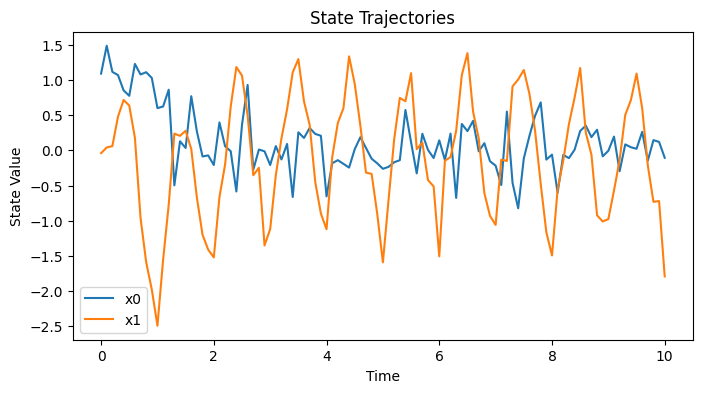

In [ ]:
X_df= sys.simulate_states(x0=x0, dt=0.1, t_span=(0, 10), 
                           override_system_f=driven_SHO_with_params(damping_term=2,stiffness=3), 
                           override_system_Q=process_noise_with_params(noise_in_x0 = 0.1,noise_in_x1=0.05), 
                           override_system_u=u_square_wave_with_params(amplitude=5,period=1), 
                           override_system_input_names=["force"],
                           output_df=True)
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

Once we are satisfied, we can update our system.

In [ ]:
sys.f = driven_SHO_with_params(damping_term=2,stiffness=3)
sys.u = u_square_wave_with_params(amplitude=5,period=1)
sys.input_names = ["force"]  
sys.Q = process_noise_with_params(noise_in_x0 = 0.1,noise_in_x1=0.1)

## Simulating Measurements

We simulate our system above to have state trajectories we can measure:

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

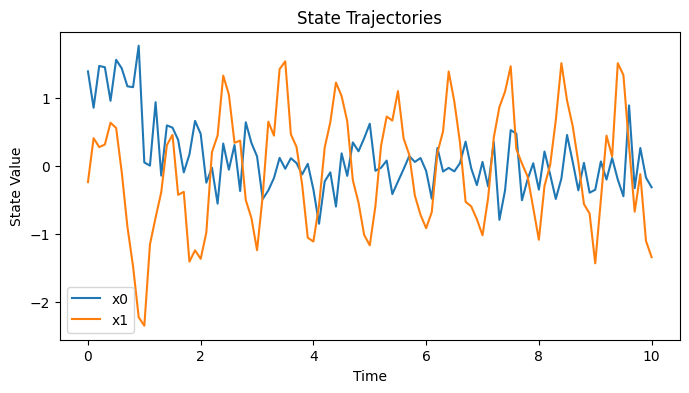

In [ ]:
X_df = sys.simulate_states(x0=x0, dt=0.1, t_span=(0, 10), 
                           override_system_f=driven_SHO_with_params(damping_term=2,stiffness=3), 
                           override_system_Q=process_noise_with_params(noise_in_x0 = 0.1,noise_in_x1=0.05), 
                           override_system_u=u_square_wave_with_params(amplitude=5,period=1), 
                           override_system_input_names=["force"],
                           output_df=True)
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

and then simulate measurements:

In [ ]:
Y_df = sys.simulate_measurements(X_df=X_df,input_df=True,output_df=True)

By default, `System` uses the identity function for measurements:

   y = h(x, u, t) + r(t) = x + r(t)

So we should not be surprised by the following plot:

<Axes: title={'center': 'True vs Measured State Values '}, xlabel='time', ylabel='State Value'>

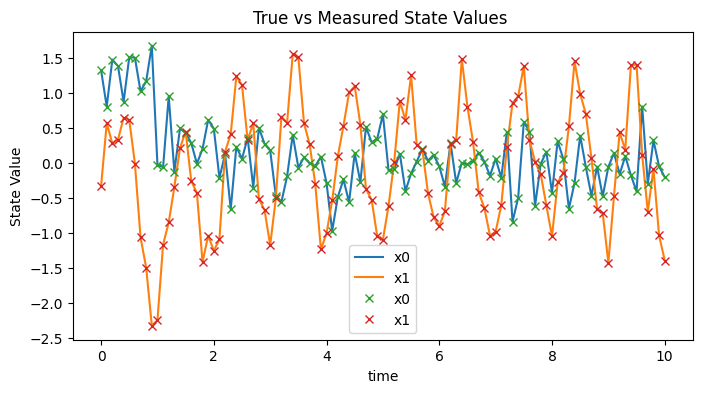

In [ ]:
ax = X_df.plot(
      title="True vs Measured State Values ", xlabel="Time", ylabel="State Value", figsize=(8, 4)
  )
ax.grid(True)  
Y_df.plot(ax=ax, style="x")

If we want to simulate sensor readings (e.g. only position), we can need to define a custom `h` and `R`. We follow a prototyping process similar to when we deterined our process dynamics and process noise. Let’s assume we only observe position with some additive Gaussian noise.  

In [ ]:
def position_sensor(x: NDArray, u: NDArray, t: float) -> NDArray:
      """Only measure position."""
      return np.array([[x[0, 0]]])  # shape (1, 1)

def test_measurement_noise() -> NDArray:
      """Constant measurement noise: variance = 0.05^2"""
      return 0.01 * np.eye(1)  # shape (1, 1)

Note that since our new h function returns only position, and not position and velocity, we mustchange sys.measurement_names from `x0` and `x1` to just `x0` for this simulation. 

In [ ]:
Y_df = sys.simulate_measurements(X_df=X_df, override_system_h = position_sensor,override_system_R=test_measurement_noise,override_system_measurement_names=["x0"], input_df=True,output_df=True)

<Axes: title={'center': 'True vs Measured x0'}, xlabel='time', ylabel='Value'>

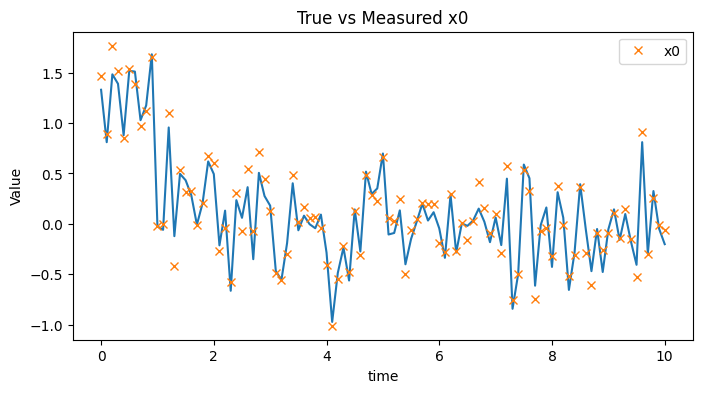

In [ ]:
ax = X_df["x0"].plot(
      title="True vs Measured x0", xlabel="Time", ylabel="Value", figsize=(8, 4)
  )
Y_df.plot(ax=ax,style="x")

Again, like earlier, we can wrap these functions in closures for convenience. 

In [ ]:
def measurement_noise_with_params(
    noise_in_x0: float = 0.01,
) -> Callable[[], NDArray[np.float64]]:

    def R() -> NDArray[np.float64]:
        return np.diag([noise_in_x0]).astype(np.float64)

    return R

<Axes: title={'center': 'True vs Measured x0'}, xlabel='time', ylabel='Value'>

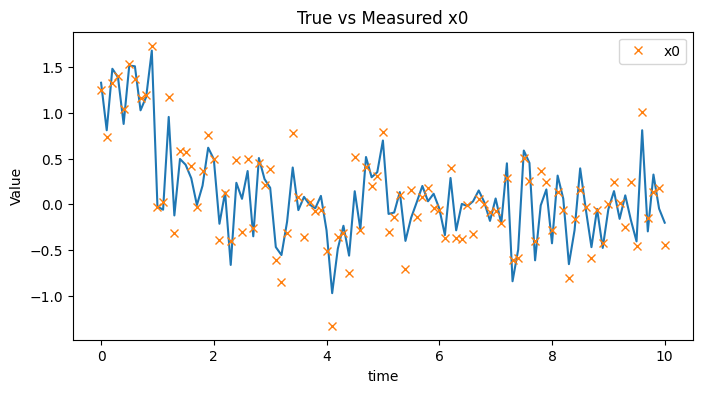

In [ ]:
Y_df= sys.simulate_measurements(X_df=X_df, 
                                 override_system_h = position_sensor,
                                 override_system_R=measurement_noise_with_params(noise_in_x0=0.05),
                                 override_system_measurement_names=["x0"],
                                 output_df=True,
                                 input_df=True)

ax = X_df["x0"].plot(
      title="True vs Measured x0", xlabel="Time", ylabel="Value", figsize=(8, 4)
  )
Y_df.plot(ax=ax,style="x")

Again, once we are satisfied, we can update our system.

In [ ]:
sys.h = position_sensor
sys.measurement_names = ["x0"]  
sys.R = measurement_noise_with_params(noise_in_x0 = 0.3)

## Visualizing the Final `System`
Once we are confident in our system attributes, we can visualize the whole thing

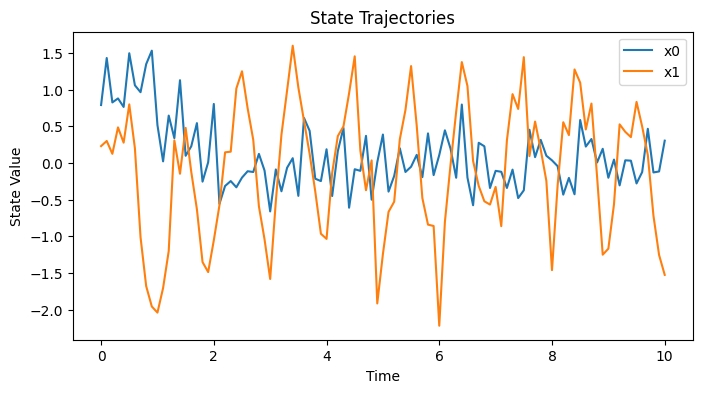

In [ ]:
X_df = sys.simulate_states(x0=x0, dt=0.1, t_span=(0, 10),output_df=True)
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))
Y_df = sys.simulate_measurements(X_df=X_df,input_df=True,output_df=True)

<Axes: title={'center': 'True vs Measured x0'}, xlabel='Time', ylabel='Value'>

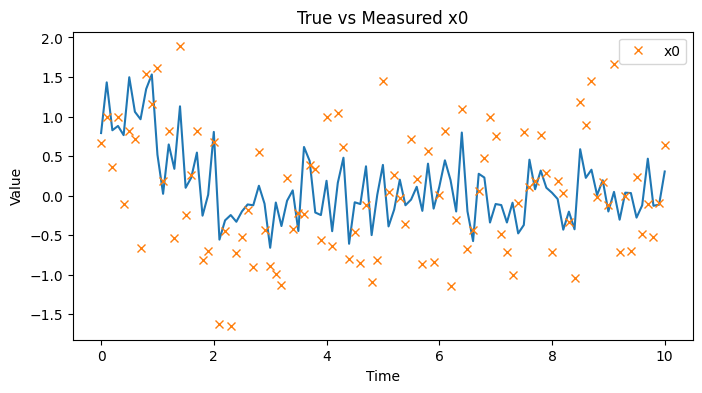

In [ ]:
ax = X_df['x0'].plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))
Y_df.plot(ax=ax,
           title="True vs Measured x0", xlabel="Time", ylabel="Value", figsize=(8, 4),
          style="x")

## Tweaking the Final `System`
And of course, if we ever want to experiment with changing things, we can do so:

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

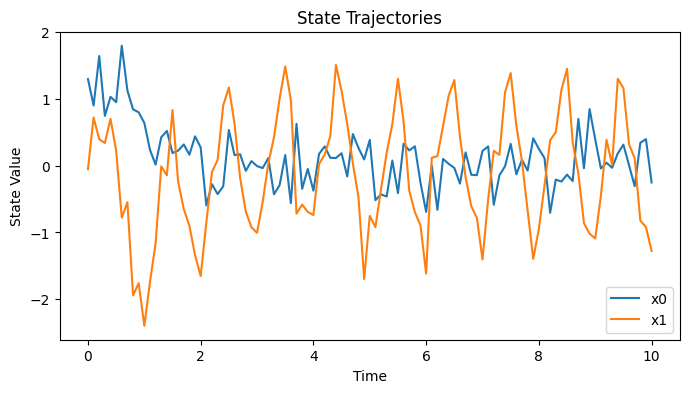

In [ ]:
X_df = sys.simulate_states(x0=x0, dt=0.1, t_span=(0, 10), 
                           override_system_f=driven_SHO_with_params(damping_term=2,stiffness=3), 
                           override_system_Q=process_noise_with_params(noise_in_x0 = 0.1,noise_in_x1=0.05), 
                           override_system_u=u_square_wave_with_params(amplitude=5,period=1), 
                           override_system_input_names=["force"],
                           output_df=True)
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))